<a href="https://colab.research.google.com/github/dslrsiddesh/biometrics-project/blob/main/pre_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_path = '/content/drive/MyDrive/tbnd_v2/'

### Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os

### Required functions

In [ ]:
def load_images(folder_path, sub_directory):
    images = []
    labels = []

    sub_dir_path = os.path.join(folder_path, sub_directory)

    if not os.path.exists(sub_dir_path):
        print("Subdirectory does not exist.")
        return images, labels
    print(f'loading image files from {sub_directory}.')
    for filename in os.listdir(sub_dir_path):
        filepath = os.path.join(sub_dir_path, filename)
        if os.path.isfile(filepath):
            img = cv2.imread(filepath)
            if img is not None:
                img = cv2.resize(img, (300, 300))
                images.append(img)
                label_name = filename.split('.')[0]
                labels.append(label_name)
    print('images loaded and scaled.')
    return images, labels

In [ ]:
def plot_image(img = None, file_path = None, title = None):
  if file_path:
    img = cv2.imread(file_path)
  print("Image Shape :", img.shape)
  plt.figure(figsize=(2, 2))
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.title(f'Subject-{title}')
  plt.show()

Image Shape : (483, 483, 3)


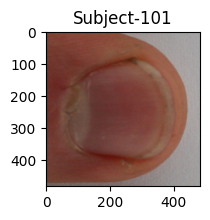

In [ ]:
plot_image(img=None, file_path=folder_path + 'D1/101.jpg', title='101')

## Preprocessing

### Scale down all images to 300pixels x 300pixels

In [ ]:
d1_images, d1_labels = load_images(folder_path, 'D1')

loading image files from D1.
images loaded and scaled.


In [ ]:
print(len(d1_images), d1_images[0].shape)

93 (300, 300, 3)


Image Shape : (300, 300, 3)


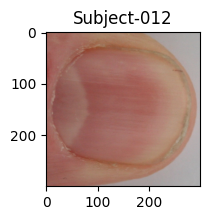

In [ ]:
plot_image(img = d1_images[0], file_path = None, title = d1_labels[0])

## Feature Extraction

### LBP Based Signature Extraction

In [ ]:
from skimage.feature import local_binary_pattern

def lbp_signature_extraction(image):
  P, R = 8, 2
  method = 'uniform'

  # Divide image into 16 blocks using a 4x4 grid
  block_size = 4
  block_height = image.shape[0] // block_size
  block_width = image.shape[1] // block_size

  histograms = []
  for i in range(3):  # for each color channel
    color_channel = image[:, :, i]
    for r in range(block_size):
        for c in range(block_size):
            block = color_channel[r*block_height:(r+1)*block_height, c*block_width:(c+1)*block_width]

            # Gaussian pyramid image set for the block
            pyramid_images = [block]
            for _ in range(2):
                block = cv2.pyrDown(block)
                pyramid_images.append(block)

            # Apply LBP for each channel of the pyramid images
            for pyr_image in pyramid_images:
                # Compute LBP
                lbp = local_binary_pattern(pyr_image, P, R, method)
                # Compute histogram
                hist = np.histogram(lbp, bins=59, range=(0, 59), density=True)[0]
                histograms.append(hist)

  return histograms

In [ ]:
print(len(lbp_signature_extraction(d1_images[0])))

144


### Descriptor Based Siganature Extraction (SIFT & BRISK)

In [ ]:
def compute_keypoints_descriptors(image):
    gftt_detector = cv2.GFTTDetector_create()
    sift = cv2.SIFT_create()
    brisk = cv2.BRISK_create()

    descriptors_sift = []
    descriptors_brisk = []

    for channel in range(3):
        monochromatic_image = image[:, :, channel]
        keypoints_channel = gftt_detector.detect(monochromatic_image)

        # Compute SIFT descriptors
        _, sift_descriptor = sift.compute(monochromatic_image, keypoints_channel)
        descriptors_sift.extend(sift_descriptor)

        # Compute BRISK descriptors
        _, brisk_descriptor = brisk.compute(monochromatic_image, keypoints_channel)
        descriptors_brisk.extend(brisk_descriptor)

    return descriptors_sift, descriptors_brisk

In [ ]:
descriptors_sift, descriptors_brisk = compute_keypoints_descriptors(d1_images[0])
print("SIFT Desriptors :", len(descriptors_sift))
print("BRISK Desriptors :", len(descriptors_brisk))


SIFT Desriptors : 3000
BRISK Desriptors : 2621


## Signature Matching

### LBP Based Signature Matching

In [ ]:
import numpy as np

def cosine_similarity(hist1, hist2):
    dot_product = np.dot(hist1, hist2)
    norm_hist1 = np.linalg.norm(hist1)
    norm_hist2 = np.linalg.norm(hist2)
    cosine_similarity = dot_product / (norm_hist1 * norm_hist2)
    return cosine_similarity

def lbp_matching_score(histograms_a, histograms_b):
    num_histograms = len(histograms_a)
    total_similarity = 0
    for i in range(num_histograms):
        similarity = cosine_similarity(histograms_a[i], histograms_b[i])
        total_similarity += similarity
    matching_score = total_similarity / num_histograms
    return matching_score

### Descriptor Based Signature Matching

In [ ]:
descriptors_sift1, descriptors_brisk1 = compute_keypoints_descriptors(d1_images[1])
print("SIFT Desriptors :", len(descriptors_sift1))
print("BRISK Desriptors :", len(descriptors_brisk1))

print(np.array(descriptors_sift1).shape)
print(np.array(descriptors_brisk1).shape)

SIFT Desriptors : 3000
BRISK Desriptors : 2516
(3000, 128)
(2516, 64)


In [ ]:
def descriptor_matching_score(descriptors1, descriptors2, num_iterations=10):
    # Convert descriptors to float32 for FLANN
    descriptors1 = descriptors1.astype(np.float32)
    descriptors2 = descriptors2.astype(np.float32)

    # Initialize FLANN-based matcher
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    consensus_percentages = []

    for _ in range(num_iterations):
        # Perform FLANN matching
        matches = flann.knnMatch(descriptors1, descriptors2, k=2)

        # Apply ratio test to filter good matches
        good_matches = []
        for m, n in matches:
            if m.distance < 0.7 * n.distance:
                good_matches.append(m)

        # Estimate homography with RANSAC
        src_pts = np.float32([descriptors1[m.queryIdx] for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([descriptors2[m.trainIdx] for m in good_matches]).reshape(-1, 1, 2)
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        # Calculate the consensus keypoint percentage
        inliers = mask.ravel().sum()
        keypoints_count = len(descriptors1)
        consensus_percentage = inliers / keypoints_count if keypoints_count > 0 else 0
        consensus_percentages.append(consensus_percentage)

    # Compute the average consensus keypoint percentage
    matching_score = sum(consensus_percentages) / len(consensus_percentages)

    return matching_score

res_sift = descriptor_matching_score(np.array(descriptors_sift, dtype=np.float32), np.array(descriptors_sift, dtype=np.float32))
res_brisk = descriptor_matching_score(np.array(descriptors_brisk, dtype=np.float32), np.array(descriptors_brisk, dtype=np.float32))
print(res_sift, res_brisk)

ValueError: too many values to unpack (expected 2)

## Signature Fusion

In [ ]:
import math

def geometric_mean(scores):
    return math.prod(scores) ** (1 / len(scores))

def fuse_signatures(lbp_score, sift_score, brisk_score):
    # Compute fusion scores
    f_ls = geometric_mean([lbp_score, sift_score])
    f_lb = geometric_mean([lbp_score, brisk_score])
    f_lbs = geometric_mean([lbp_score, sift_score, brisk_score])

    return f_ls, f_lb, f_lbs

## Evaluation

In [ ]:
# load images of D2 and D30
d2_images, d2_labels = load_images(folder_path, 'D2')
d30_images, d30_labels = load_images(folder_path, 'D30')

loading image files from D2.
images loaded and scaled.
loading image files from D30.
images loaded and scaled.


In [ ]:
# lbp based feature extraction of all the images of D1, D2, D30
def lbp_for_all_images(images):
  lbp_features = []
  for image in images:
    lbp_features.append(lbp_signature_extraction(image))
  return lbp_features

d1_lbp_features = lbp_for_all_images(d1_images)
d2_lbp_features = lbp_for_all_images(d2_images)
d30_lbp_features = lbp_for_all_images(d30_images)

In [ ]:
print(f' Shape of LBP Features : {len(d1_lbp_features)} x {len(d1_lbp_features[0])} x {len(d1_lbp_features[0][0])}')

 Shape of LBP Features : 93 x 144 x 59


In [ ]:
# descriptor based feature extraction of all the images of D1, D2, D30
def descriptors_for_all_images(images):
  all_sift_descriptors, all_brisk_descriptors = [], []
  for image in images:
    sift_descriptors, brisk_descriptors = compute_keypoints_descriptors(image)
    all_sift_descriptors.append(sift_descriptors)
    all_brisk_descriptors.append(brisk_descriptors)
  return all_sift_descriptors, all_brisk_descriptors

d1_sift_descritors, d1_brisk_descritors = descriptors_for_all_images(d1_images)
d2_sift_descritors, d2_brisk_descritors = descriptors_for_all_images(d2_images)
d30_sift_descritors, d30_brisk_descritors = descriptors_for_all_images(d30_images)